In [1]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import time
import datetime, calendar
import scipy.stats as stats
import statsmodels.api as sm
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Mecab
import nltk
import re
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from konlpy.tag import Mecab
from tensorflow.keras import layers, models
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 병합

In [2]:
train_data = pd.read_csv('train.csv')
train_data.index = pd.to_datetime(train_data['일자'])
del train_data['조식메뉴'], train_data['중식메뉴'], train_data['석식메뉴'], train_data['일자']

cases = pd.read_csv('일일코로나확진자.csv')
cases = cases[(cases['Entity'] == 'South Korea')].iloc[:, [2, 3]].reset_index(drop=True)
cases.index = pd.to_datetime(cases['Day'])
del cases['Day']
cases.columns = ['확진자수']
cases = cases[cases.index < '2021-04-10']


temp = pd.read_csv('진주시_기온정보.csv', encoding='euc-kr')
temp.index = pd.to_datetime(temp['날짜'])
del temp['날짜'], temp['지점']

hum = pd.read_csv('진주시강수량.csv', encoding='euc-kr')
hum.index = pd.to_datetime(hum['날짜'])
del hum['날짜'], hum['지점']
hum.fillna(0, inplace=True)


heat_idx = pd.read_csv('진주시_열지수_정보.csv', encoding='euc-kr')
heat_idx['일자'] = heat_idx['일자'].apply(lambda row: str(row)[:4] + '-' + str(row)[4:6] + '-' + str(row)[-2:])
heat_idx.index = pd.to_datetime(heat_idx['일자'])
heat_idx = heat_idx.loc[:, ['습도(%)', '열지수']]

train_data = pd.concat([train_data, temp, cases, hum, heat_idx], axis=1)
train_data = train_data[~train_data['본사정원수'].isnull()].fillna(0.)
train_data.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,평균기온(℃),최저기온(℃),최고기온(℃),확진자수,강수량(mm),습도(%),열지수
2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,-0.6,-4.1,5.0,0.0,0.0,44.1,-0.22
2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,867.0,560.0,-2.3,-9.1,6.2,0.0,0.0,47.2,-2.32
2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,1017.0,573.0,-1.7,-9.3,7.7,0.0,0.0,56.2,-1.94
2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,978.0,525.0,-0.2,-7.7,7.7,0.0,0.0,55.3,-0.55
2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,925.0,330.0,1.3,-6.5,9.6,0.0,0.0,42.7,1.51


- 아래의 그래프에 따르면, 중식계에는 요일 간에 체계적인 차이가 존재하는 것처럼 보인다.

    - 월요일에 중식을 많이 하고, 금요일로 갈수록 밖에서 식사하는 비중이 높아진다.
    
    
- 반면 석식의 경우, 요일별 편차가 크지 않다. 금요일의 경우는 금요일에 정시 퇴근 후 금요일 밤에 회식이나 모임 등을 가지는 경우가 많아서 석식 결식률이 높은 것으로 판단된다.


- 그러나 수요일은 마땅한 이유가 없는데 석식 결식률이 매우 높다. 이에 대한 확인이 필요해 보인다.

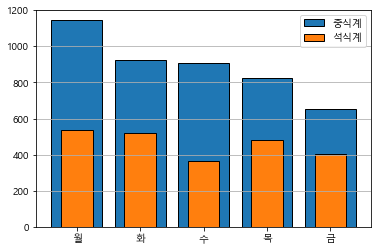

In [3]:
lunch_by_day = train_data.groupby('요일')['중식계'].mean()[['월', '화', '수', '목', '금']]
plt.grid(axis='y')
plt.bar(lunch_by_day.index, lunch_by_day.values, edgecolor='k', label='중식계')
dinner_by_day = train_data.groupby('요일')['석식계'].mean()[['월', '화', '수', '목', '금']]
plt.bar(dinner_by_day.index, dinner_by_day.values, edgecolor='k', width=0.5, label='석식계')
plt.legend();

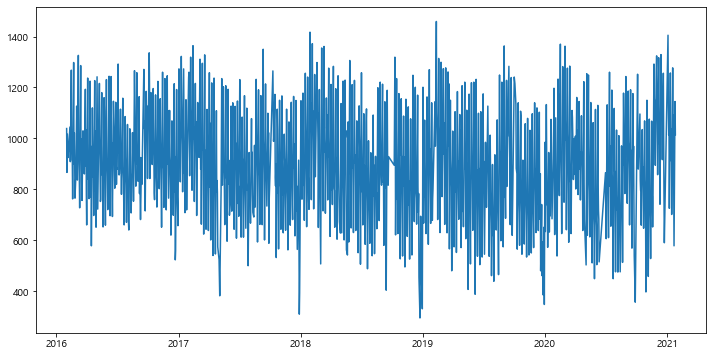

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data['중식계']);

- 보시는 바와 같이, 주기적으로 석식계가 0인 사건이 일어남을 line chart에서 확인할 수 있다.


- 또한 최근에 올 수록, 코로나19의 영향인지 모르겠으나 석식계의 편차가 커짐을 볼 수 있다.



- 마지막으로 seasonality가 존재하는 것을 볼 수 있다. 날씨나 기온 같은 계절적 요인들로 인한 seasonality 같으므로 기후 요소를 데이터에 포함시킨다.

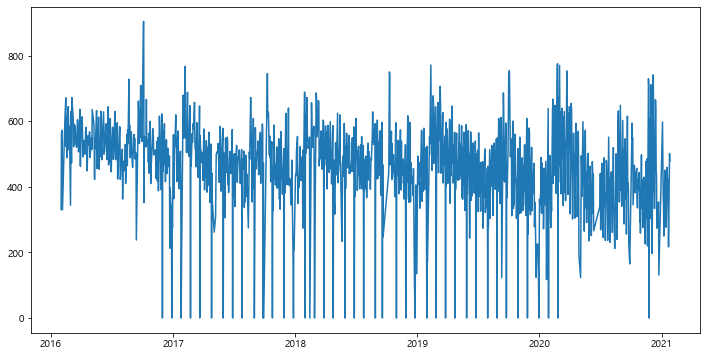

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_data['석식계']);

- 석식계가 주기적으로 0이 되는 사건은 매달 마지막 수요일에 벌어지는 것으로 확인되었다. 이는 `문화가 있는 날`로 선정되는 날들로, 이 때 LH는 정시에 퇴근하고 여가를 즐길 것을 강제하기에 석식계가 0인 것으로 판단된다.



- 다만 매달 마지막 수요일인 `문화가 있는 날` 이외에도 석식계가 0인 사건이 존재하므로 무조건 `문화가 있는 날`만이 석식계가 0인 것은 아니며, 반대로 코로나가 대유행하던 시기인 2020년 2월부터 10월까지는 `문화가 있는 날`임에도 석식계가 0이 아니다. 이에 대한 주의가 필요하다.

In [6]:
train_data[train_data['석식계'] == 0].head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,평균기온(℃),최저기온(℃),최고기온(℃),확진자수,강수량(mm),습도(%),열지수
2016-11-30,수,2689.0,68.0,207.0,0.0,0.0,1109.0,0.0,7.0,1.4,10.6,0.0,4.5,68.8,6.45
2016-12-28,수,2705.0,166.0,225.0,0.0,0.0,767.0,0.0,-0.5,-6.8,7.9,0.0,0.0,52.8,-0.58
2017-01-25,수,2697.0,79.0,203.0,0.0,0.0,720.0,0.0,-3.1,-11.0,7.1,0.0,0.0,49.1,-3.21
2017-02-22,수,2632.0,75.0,252.0,0.0,0.0,1065.0,0.0,3.4,-2.2,5.1,0.0,30.1,83.0,2.81
2017-03-22,수,2627.0,53.0,235.0,0.0,0.0,953.0,0.0,6.9,-1.1,14.5,0.0,0.0,56.3,6.43


- 강수량을 기준으로 비가 오거나 눈이 내리는 날이 중식계가 증가하는 것을 확인하였다. 아무래도 비가 오므로 밖에서 점심을 먹는 것을 기피하게 되는 듯 하다.

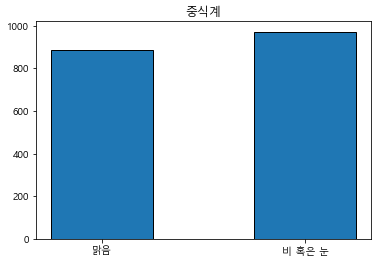

In [7]:
criterion = 30
plt.bar(['맑음', '비 혹은 눈'],
        [train_data[train_data['강수량(mm)'] <= criterion]['중식계'].mean(), train_data[train_data['강수량(mm)'] > criterion]['중식계'].mean()],
        edgecolor='k',
        width=0.5)
plt.title('중식계');

              중식계   강수량(mm)
중식계      1.000000  0.088758
강수량(mm)  0.088758  1.000000


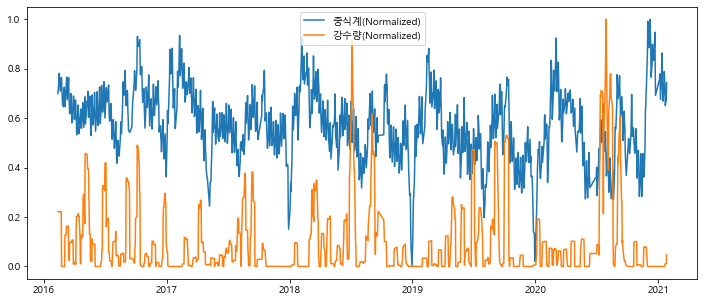

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
dinner_ma = train_data['중식계'].rolling(7).mean()
minmax_dinner = (dinner_ma - dinner_ma.min()) / (dinner_ma.max() - dinner_ma.min())

rain_ma = train_data['강수량(mm)'].rolling(7).mean()
minmax_rain = (rain_ma - rain_ma.min())/(rain_ma.max() - rain_ma.min())

ax.plot(minmax_dinner, label='중식계(Normalized)')
ax.plot(minmax_rain, label='강수량(Normalized)');
ax.legend();
print(train_data[['중식계', '강수량(mm)']].corr(method='pearson'))

- 그러나 석식계에서는 비가 오거나 눈이 내리는 날과 맑은 날에 차이가 거의 존재하지 않는 것으로 보인다.


- 다만 100mm 이상의 폭우가 내리는 날에는 확연히 석식을 LH에서 먹고가는 비율이 증가하는 것을 확인하였다.

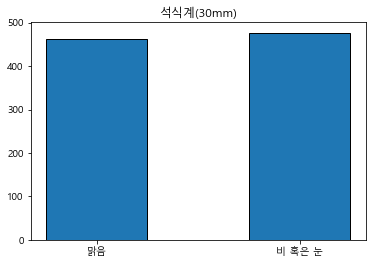

In [9]:
criterion = 30
plt.bar(['맑음', '비 혹은 눈'],
        [train_data[train_data['강수량(mm)'] <= criterion]['석식계'].mean(), train_data[train_data['강수량(mm)'] > criterion]['석식계'].mean()],
        edgecolor='k',
        width=0.5)
plt.title(f'석식계({criterion}mm)');

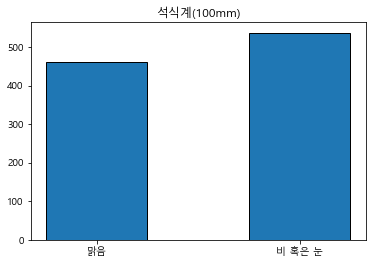

In [10]:
criterion = 100
plt.bar(['맑음', '비 혹은 눈'],
        [train_data[train_data['강수량(mm)'] <= 10]['석식계'].mean(), train_data[train_data['강수량(mm)'] > criterion]['석식계'].mean()],
        edgecolor='k',
        width=0.5)
plt.title(f'석식계({criterion}mm)');

              석식계   강수량(mm)
석식계      1.000000  0.027613
강수량(mm)  0.027613  1.000000


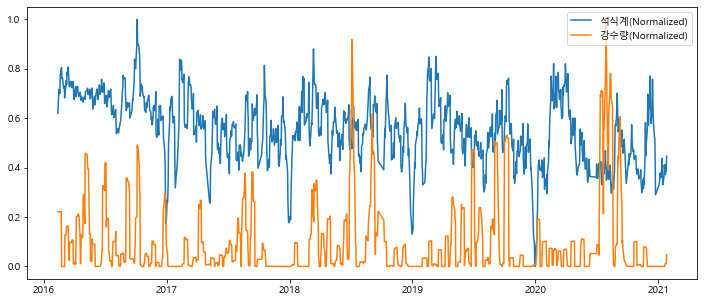

In [11]:
fig, ax = plt.subplots(figsize=(12,5))
dinner_ma = train_data['석식계'].rolling(7).mean()
minmax_dinner = (dinner_ma - dinner_ma.min()) / (dinner_ma.max() - dinner_ma.min())

rain_ma = train_data['강수량(mm)'].rolling(7).mean()
minmax_rain = (rain_ma - rain_ma.min())/(rain_ma.max() - rain_ma.min())

ax.plot(minmax_dinner, label='석식계(Normalized)')
ax.plot(minmax_rain, label='강수량(Normalized)');
ax.legend();
print(train_data[['석식계', '강수량(mm)']].corr(method='pearson'))

## 다른 요건들이 비슷한 row들끼리 석식계(중식계)와 강수량 간의 관계를 한번 나중에 구해보자.

In [12]:
def week_of_month(dt):

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return str(int(np.ceil(adjusted_dom/7.0)))


def MunhwaDay(row):
    if row['요일'] == '수' and row['석식계'] == 0 and int(row['주차'][0]) >= 4 :
        return 1
    else:
        return 0
    
def LastWedInMonth(year, month, date):

    daysInMonth = calendar.monthrange(year, month)[1]   
    dt = datetime.date(year, month, daysInMonth)

    offset = 3 - dt.isoweekday()
    if offset > 0: offset -= 7                         
    dt += datetime.timedelta(offset)                   

    if dt == date:
        return 1
    else:
        return 0
    
train_data['개월'] = [f'{date.month}월' for date in train_data.index]
train_data['주차'] = [f'{week_of_month(date)}주차' for date in train_data.index]
train_data['문화day'] = train_data.apply(lambda row : MunhwaDay(row), axis=1)

test_data = pd.read_csv('test.csv')
test_data.index = pd.to_datetime(test_data['일자'])
del test_data['조식메뉴'], test_data['중식메뉴'], test_data['석식메뉴'], test_data['일자']
test_data = pd.concat([test_data, temp, cases, hum, heat_idx], axis=1)
test_data = test_data[~test_data['본사정원수'].isnull()].fillna(0.)
test_data['개월'] = [f'{date.month}월' for date in test_data.index]
test_data['주차'] = [f'{week_of_month(date)}주차' for date in test_data.index]
#test_data['문화day'] = [LastWedInMonth(date.year, date.month, date) for date in test_data.index]
test_data['문화day'] = [0 for i in range(len(test_data))]

In [13]:
whole_df = pd.concat([train_data, test_data], axis=0)
whole_df.head()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,평균기온(℃),최저기온(℃),최고기온(℃),확진자수,강수량(mm),습도(%),열지수,개월,주차,문화day
2016-02-01,월,2601.0,50.0,150.0,238.0,0.0,1039.0,331.0,-0.6,-4.1,5.0,0.0,0.0,44.1,-0.22,2월,1주차,0
2016-02-02,화,2601.0,50.0,173.0,319.0,0.0,867.0,560.0,-2.3,-9.1,6.2,0.0,0.0,47.2,-2.32,2월,1주차,0
2016-02-03,수,2601.0,56.0,180.0,111.0,0.0,1017.0,573.0,-1.7,-9.3,7.7,0.0,0.0,56.2,-1.94,2월,1주차,0
2016-02-04,목,2601.0,104.0,220.0,355.0,0.0,978.0,525.0,-0.2,-7.7,7.7,0.0,0.0,55.3,-0.55,2월,1주차,0
2016-02-05,금,2601.0,278.0,181.0,34.0,0.0,925.0,330.0,1.3,-6.5,9.6,0.0,0.0,42.7,1.51,2월,1주차,0


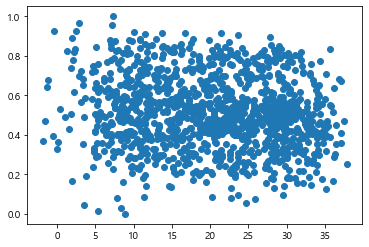

In [17]:
lunch_normed = (whole_df['중식계'] - whole_df['중식계'].min()) / (whole_df['중식계'].max() - whole_df['중식계'].min())
plt.scatter(whole_df['최고기온(℃)'], lunch_normed)

In [250]:
day_dummy = pd.get_dummies(whole_df['요일'])
month_dummy = pd.get_dummies(whole_df['개월'])
week_dummy = pd.get_dummies(whole_df['주차'])
whole_df = pd.concat([whole_df, day_dummy, month_dummy, week_dummy], axis=1)
drop_cols = ['요일', '개월', '주차']
whole_df.drop(drop_cols, axis=1, inplace=True)
whole_df = sm.add_constant(whole_df)
train_y_lunch = whole_df['중식계'].dropna()
train_y_dinner = whole_df['석식계'].dropna()
del whole_df['중식계'], whole_df['석식계']

In [251]:
train_x, test_x = whole_df.iloc[:len(train_data),:], whole_df.iloc[len(train_data):,:]

In [252]:
res1 = sm.OLS(train_y_lunch, train_x, missing='drop').fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    중식계   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     153.3
Date:                Wed, 23 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:57:45   Log-Likelihood:                -7142.7
No. Observations:                1205   AIC:                         1.435e+04
Df Residuals:                    1171   BIC:                         1.453e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1164.8459     38.930     29.921      0.000    1088.465    1241.227
본사정원수             -0.1117      0.021     -5.224      0.000      -0.154      -0.070
본사휴가자수            -0.6424      0.031    -20.838      0.000      -0.703      -0.582
본사출장자수            -1.6989      0.118    -14.350      0.000      -1.931      -1.467
본사시간외근무명령서승인건수     0.1932      0.024      7.926      0.000       0.145       0.241
현본사소속재택근무자수       -0.1883      0.039     -4.811      0.000      -0.265      -0.112
평균기온(℃)           -3.0080      4.232     -0.711      0.477     -11.310       5.294
최저기온(℃)            2.2445      2.108      1.065      0.287      -1.892       6.381
최고기온(℃)           -2.4131      1.840     -1.312      0.190      -6.023       1.197
확진자수               0.2226      0.026      8.725      0.000       0.173       0.273
강수량(mm)            0.9444      0.236      4.001      0.000       0.481       1.408
습도(%)              0.0106      0.271      0.039      0.969      -0.521       0.542
열지수                2.5580      3.412      0.750      0.454      -4.135       9.251
문화day              8.6776     17.295      0.502      0.616     -25.254      42.609
금                150.5036     12.706     11.845      0.000     125.575     175.432
목                156.2347     10.097     15.474      0.000     136.425     176.045
수                267.0525     12.422     21.499      0.000     242.681     291.424
월                397.9330     10.351     38.443      0.000     377.624     418.242
화                193.1220      9.880     19.546      0.000     173.737     212.507
10월              149.1155     10.670     13.975      0.000     128.180     170.051
11월               89.0962     11.144      7.995      0.000      67.233     110.960
12월               35.1521     14.504      2.424      0.016       6.695      63.610
1월                57.2210     15.946      3.588      0.000      25.935      88.507
2월               123.2980     14.080      8.757      0.000      95.674     150.922
3월                92.9983     10.688      8.701      0.000      72.029     113.967
4월                77.7187      9.448      8.226      0.000      59.182      96.256
5월               102.6797     11.122      9.232      0.000      80.858     124.501
6월                73.6517     13.633      5.402      0.000      46.904     100.400
7월                79.2166     15.314      5.173      0.000      49.171     109.262
8월               169.5016     17.328      9.782      0.000     135.504     203.499
9월               115.1964     13.348      8.630      0.000      89.007     141.385
1주차              217.5245     10.708     20.315      0.000     196.516     238.533
2주차              205.2713      9.114     22.524      0.000     187.390     223.152
3주차              200.8842      9.181     21.881      0.000     182.871     218.897
4주차         

In [253]:
res2 = sm.OLS(train_y_dinner, train_x, missing='drop').fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    석식계   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     115.3
Date:                Wed, 23 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:57:46   Log-Likelihood:                -6785.4
No. Observations:                1205   AIC:                         1.364e+04
Df Residuals:                    1171   BIC:                         1.381e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            634.7072     28.942     21.930      0.000     577.923     691.491
본사정원수             -0.1017      0.016     -6.398      0.000      -0.133      -0.071
본사휴가자수            -0.3423      0.023    -14.936      0.000      -0.387      -0.297
본사출장자수            -0.7014      0.088     -7.969      0.000      -0.874      -0.529
본사시간외근무명령서승인건수     0.3035      0.018     16.751      0.000       0.268       0.339
현본사소속재택근무자수       -0.2315      0.029     -7.953      0.000      -0.289      -0.174
평균기온(℃)           -4.3845      3.146     -1.394      0.164     -10.557       1.788
최저기온(℃)            0.2743      1.567      0.175      0.861      -2.801       3.349
최고기온(℃)            0.5761      1.368      0.421      0.674      -2.108       3.260
확진자수               0.0519      0.019      2.739      0.006       0.015       0.089
강수량(mm)            0.5452      0.175      3.107      0.002       0.201       0.889
습도(%)             -0.4871      0.201     -2.420      0.016      -0.882      -0.092
열지수                5.1660      2.536      2.037      0.042       0.190      10.142
문화day           -428.4606     12.857    -33.325      0.000    -453.686    -403.235
금                179.1400      9.446     18.965      0.000     160.608     197.672
목                102.2806      7.506     13.626      0.000      87.554     117.008
수                150.6079      9.235     16.309      0.000     132.490     168.726
월                106.0716      7.695     13.784      0.000      90.973     121.170
화                 96.6071      7.345     13.152      0.000      82.196     111.019
10월               77.4405      7.933      9.762      0.000      61.877      93.004
11월               50.7808      8.284      6.130      0.000      34.527      67.035
12월               16.7822     10.783      1.556      0.120      -4.374      37.938
1월                14.8275     11.855      1.251      0.211      -8.431      38.086
2월                73.5926     10.467      7.031      0.000      53.056      94.129
3월                81.5694      7.945     10.266      0.000      65.980      97.158
4월                64.7250      7.024      9.215      0.000      50.944      78.506
5월                45.9348      8.268      5.555      0.000      29.712      62.157
6월                33.7818     10.135      3.333      0.001      13.897      53.667
7월                28.0841     11.385      2.467      0.014       5.747      50.421
8월                90.8559     12.882      7.053      0.000      65.581     116.131
9월                56.3325      9.923      5.677      0.000      36.863      75.802
1주차               98.2374      7.960     12.341      0.000      82.619     113.855
2주차              102.3375      6.775     15.104      0.000      89.044     115.631
3주차               95.4037      6.825     13.978      0.000      82.013     108.795
4주차         

# Deep Learning

In [254]:
del train_x['const'], test_x['const']

In [255]:
def MinMax(col):
    min_ = col.min()
    max_ = col.max()
    if min_ == 0 and max_ == 1:
        return col
    elif min_ == 0 and max_ == 0:
        return col
    else:
        return (col - min_) / (max_ - min_)
    
train_x = train_x.apply(lambda col : MinMax(col), axis=0)
test_x = test_x.apply(lambda col : MinMax(col), axis=0)

train_lunch_min = train_y_lunch.min()
train_lunch_max = train_y_lunch.max()

train_y_lunch = (train_y_lunch - train_lunch_min) / (train_lunch_max - train_lunch_min)

train_dinner_min = train_y_dinner.min()
train_dinner_max = train_y_dinner.max()

train_y_dinner = (train_y_dinner - train_dinner_min) / (train_dinner_max - train_dinner_min)


x = train_x.iloc[:-100,:].values
y_lunch = train_y_lunch[:-100].values
y_dinner = train_y_dinner[:-100].values

x_val = train_x.iloc[-100:, :].values
y_lunch_val = train_y_lunch[-100:].values
y_dinner_val = train_y_dinner[-100:].values



In [266]:
from keras import layers, models


lunch = models.Sequential()
lunch.add(layers.Dense(16, activation='relu', input_shape=(36,)))
lunch.add(layers.Dense(4, activation='relu'))
lunch.add(layers.Dense(1))

lunch.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = lunch.fit(train_x, train_y_lunch,
                    epochs = 300, batch_size=128,
                    verbose=0)

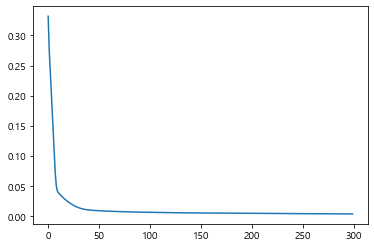

In [267]:
plt.plot(history.history['loss']);

In [268]:
dinner = models.Sequential()
dinner.add(layers.Dense(16, activation='relu', input_shape=(36,)))
dinner.add(layers.Dense(4, activation='relu'))
dinner.add(layers.Dense(1))

dinner.compile(optimizer='adam',
              loss = 'mse',
              metrics = ['mae'])

history = dinner.fit(train_x, train_y_dinner,
                    epochs = 300, batch_size=128,
                    verbose=0)

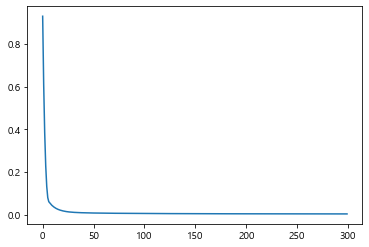

In [269]:
plt.plot(history.history['loss']);

In [261]:
sub = pd.read_csv('sample_submission.csv')
sub['중식계'] = lunch.predict(test_x) * (train_lunch_max - train_lunch_min) + train_lunch_min
sub['석식계'] = dinner.predict(test_x) * (train_dinner_max - train_dinner_min) + train_dinner_min

In [262]:
sub.to_csv('submission_dense.csv', index=False)

In [265]:
dinner.predict(test_x) * (train_dinner_max - train_dinner_min) + train_dinner_min

array([[275.8163 ],
       [330.9826 ],
       [207.66458],
       [660.10144],
       [573.4825 ],
       [509.94867],
       [569.1576 ],
       [386.1661 ],
       [670.1304 ],
       [549.9683 ],
       [176.87994],
       [678.89594],
       [667.12274],
       [337.83575],
       [469.84232],
       [340.82913],
       [798.32117],
       [748.6052 ],
       [458.5488 ],
       [545.3895 ],
       [453.42328],
       [579.37964],
       [429.19183],
       [547.9665 ],
       [462.23618],
       [639.9804 ],
       [707.65295],
       [469.9707 ],
       [496.1782 ],
       [472.68756],
       [603.641  ],
       [561.3542 ],
       [366.21426],
       [449.6532 ],
       [416.97406],
       [588.63245],
       [497.4509 ],
       [429.09152],
       [442.4701 ],
       [380.18106],
       [644.4299 ],
       [630.3169 ],
       [420.62018],
       [461.0226 ],
       [291.92392],
       [574.2826 ],
       [532.32544],
       [406.8504 ],
       [477.0678 ],
       [271.332  ]],